<a href="https://colab.research.google.com/github/MarioAvolio/FoodX-251-Pytorch-Approach/blob/main/FoodX_251_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

!pip install torch_summary
from torchsummary import summary

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

NUM_CLASSES=251

G_DRIVE='/content/gdrive/'
PROJ_PATH= G_DRIVE+"MyDrive/Visual-Proj/"

# ----------------- tar
TRAIN_PATH = PROJ_PATH + "train.tar"
VAL_PATH = PROJ_PATH + "val.tar"
VAL_DEGRADED_PATH = PROJ_PATH + "val_degraded.zip"
NOISE_TRAINING_DATA_PATH = PROJ_PATH + "noise.zip"
ANNOTATION_PATH = PROJ_PATH + "annot.tar"


# ---------------- local data extracted
TRAIN_PATH_LOCAL="/content/train_set/"
VAL_DEGRADED_PATH_LOCAL="/content/val_set_degraded/"
VAL_PATH_LOCAL="/content/val_set/"
NOISED_PATH_LOCAL="/content/noise/"


# --------------- csv file
ANNOTATION_PATH_CLASS_LOCAL="/content/class_list.txt"
ANNOTATION_PATH_VALIDATION_CLEANED="/content/val_info.csv"
ANNOTATION_PATH_TRAIN_CLEANED=PROJ_PATH+"train_info_cleaned.csv"
ANNOTATION_PATH_BALANCED_TRAIN = PROJ_PATH + "balanced_train_info.csv"






In [3]:
def get_img_from_path(path):
  return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)  


In [4]:
def initilize_path_into_val_dataset(row):
  return VAL_PATH_LOCAL + row.NAME

def initilize_path_into_val_dataset_degraded(row):
  return VAL_DEGRADED_PATH_LOCAL + row.NAME

In [5]:
def initilize_path_into_dataset(row):
  if row.NOISED == 0:
    row.PATH = TRAIN_PATH_LOCAL + row.NAME
  elif row.NOISED == 1:
    row.PATH = NOISED_PATH_LOCAL + row.NAME

  return row.PATH

In [6]:
def one_hot(data):
  y = pd.get_dummies(data.TYPE, prefix='Type')
  data = data.drop('TYPE', axis=1)
  data = pd.concat([data, y], axis=1) # add new hot-encoded columns 
  return data

In [7]:
def bound_instances_by_class(class_type,data):
  g = data[data.TYPE == class_type]
  g = g.sample(frac=0.2)
  data.drop(g.index, axis=0, inplace=True)
  
  return g.reset_index(drop=True)

In [8]:
def save_model(model, epoch):

  '''
  Running torch.save(model.state_dict(), 'mymodel.pth') will save this
  model in a Python serialized format on the disk with the name mymodel.pth. A good
  practice is to transfer the model to the CPU before calling torch.save as this will
  save tensors as CPU tensors and not as CUDA tensors. This will help in loading the
  model onto any machine, whether it contains CUDA capabilities or not
  '''
  model_path = PROJ_PATH+model.__class__.__name__+".pth"

  state = {
      'state': model.state_dict(),
      'epoch': epoch
      }
  torch.save(state, model_path)

In [9]:
drive.mount(G_DRIVE, force_remount=True)

Mounted at /content/gdrive/


In [10]:
!tar -xf $TRAIN_PATH --skip-old-files 
!tar -xf $VAL_PATH --skip-old-files 
!tar -xf $ANNOTATION_PATH --skip-old-files 
!unzip -nqq $VAL_DEGRADED_PATH  
!unzip -nqq $NOISE_TRAINING_DATA_PATH  

# DATA

In [11]:
colnames=['ID', 'TYPE'] 
class_list = pd.read_csv(ANNOTATION_PATH_CLASS_LOCAL, delim_whitespace=True, index_col=False, header=None, names=colnames).set_index('ID')
id_to_type = class_list["TYPE"].to_dict()
type_to_id = {v: k for k, v in id_to_type.items()}

In [12]:
train_info = pd.read_csv(ANNOTATION_PATH_BALANCED_TRAIN)#.sample(frac=0.05).reset_index(drop=True) # shuffle
name_to_type_train=train_info.set_index("NAME").to_dict()["TYPE"]
type_to_name_train = {v: k for k, v in name_to_type_train.items()}

In [13]:
train_info

,NAME,TYPE,NOISED
0,train_050929.jpg,149,1
1,train_068867.jpg,205,0
2,train_079959.jpg,61,0
3,train_058377.jpg,85,0
4,train_002190.jpg,140,1
...,...,...,...
128256,train_083140.jpg,139,0
128257,train_101019.jpg,174,0
128258,train_001371.jpg,58,1
128259,train_062550.jpg,2,0


In [14]:
colnames=['NAME', 'TYPE'] 
test_info = pd.read_csv(ANNOTATION_PATH_VALIDATION_CLEANED, index_col=False, header=None, names=colnames)
name_to_type_val=test_info.set_index("NAME").to_dict()["TYPE"]
type_to_name_val = {v: k for k, v in name_to_type_val.items()}
# type_to_name_val

In [15]:
test_info = test_info.sample(frac=1).reset_index(drop=True) # shuffle

In [16]:

test_info

,NAME,TYPE
0,val_000266.jpg,111
1,val_010578.jpg,226
2,val_009627.jpg,170
3,val_009396.jpg,123
4,val_007412.jpg,122
...,...,...
11989,val_004395.jpg,204
11990,val_000583.jpg,173
11991,val_001811.jpg,2
11992,val_010055.jpg,4


In [17]:
test_info["PATH"] = 0
test_info["PATH"] = test_info.apply(initilize_path_into_val_dataset, axis=1)

In [18]:
test_info

,NAME,TYPE,PATH
0,val_000266.jpg,111,/content/val_set/val_000266.jpg
1,val_010578.jpg,226,/content/val_set/val_010578.jpg
2,val_009627.jpg,170,/content/val_set/val_009627.jpg
3,val_009396.jpg,123,/content/val_set/val_009396.jpg
4,val_007412.jpg,122,/content/val_set/val_007412.jpg
...,...,...,...
11989,val_004395.jpg,204,/content/val_set/val_004395.jpg
11990,val_000583.jpg,173,/content/val_set/val_000583.jpg
11991,val_001811.jpg,2,/content/val_set/val_001811.jpg
11992,val_010055.jpg,4,/content/val_set/val_010055.jpg


In [19]:
train_info["PATH"] = 0
train_info["PATH"] = train_info.apply(initilize_path_into_dataset, axis=1)

In [20]:
train_info

,NAME,TYPE,NOISED,PATH
0,train_050929.jpg,149,1,/content/noise/train_050929.jpg
1,train_068867.jpg,205,0,/content/train_set/train_068867.jpg
2,train_079959.jpg,61,0,/content/train_set/train_079959.jpg
3,train_058377.jpg,85,0,/content/train_set/train_058377.jpg
4,train_002190.jpg,140,1,/content/noise/train_002190.jpg
...,...,...,...,...
128256,train_083140.jpg,139,0,/content/train_set/train_083140.jpg
128257,train_101019.jpg,174,0,/content/train_set/train_101019.jpg
128258,train_001371.jpg,58,1,/content/noise/train_001371.jpg
128259,train_062550.jpg,2,0,/content/train_set/train_062550.jpg


In [21]:
# val_info = bound_instances_by_class(0, train_info)
# for class_type in range(1,NUM_CLASSES):
#   g = bound_instances_by_class(class_type, train_info)
#   val_info=pd.concat([val_info,g], axis=0)

# val_info = val_info.sample(frac=1).reset_index(drop=True) # shuffle
# val_info.groupby("TYPE").size()

In [22]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_info.NAME.unique(), test_size=0.2, random_state=42, shuffle=True) # an img can live or in val or in train but not in both!

In [23]:
train, val

(array(['train_008215.jpg', 'train_047778.jpg', 'train_008182.jpg', ...,
        'train_063218.jpg', 'train_081344.jpg', 'train_009943.jpg'],
       dtype=object),
 array(['train_070483.jpg', 'train_087748.jpg', 'train_109881.jpg', ...,
        'train_102402.jpg', 'train_011670.jpg', 'train_105745.jpg'],
       dtype=object))

In [24]:
list(set(train) & set(val)) # inersection

[]

In [25]:
val_info = train_info[train_info.NAME.isin(val)].sample(frac=1).reset_index(drop=True) # shuffle

In [26]:
train_info = train_info[train_info.NAME.isin(train)].sample(frac=1).reset_index(drop=True) # shuffle

In [27]:
val_info

,NAME,TYPE,NOISED,PATH
0,train_070945.jpg,209,0,/content/train_set/train_070945.jpg
1,train_013800.jpg,203,0,/content/train_set/train_013800.jpg
2,train_005031.jpg,113,1,/content/noise/train_005031.jpg
3,train_081862.jpg,48,1,/content/noise/train_081862.jpg
4,train_048585.jpg,130,0,/content/train_set/train_048585.jpg
...,...,...,...,...
25480,train_011843.jpg,31,0,/content/train_set/train_011843.jpg
25481,train_081865.jpg,48,0,/content/train_set/train_081865.jpg
25482,train_079703.jpg,186,0,/content/train_set/train_079703.jpg
25483,train_077742.jpg,128,0,/content/train_set/train_077742.jpg


In [28]:
train_info

,NAME,TYPE,NOISED,PATH
0,train_106026.jpg,219,0,/content/train_set/train_106026.jpg
1,train_092731.jpg,198,1,/content/noise/train_092731.jpg
2,train_075796.jpg,11,0,/content/train_set/train_075796.jpg
3,train_111337.jpg,231,0,/content/train_set/train_111337.jpg
4,train_082594.jpg,97,0,/content/train_set/train_082594.jpg
...,...,...,...,...
102771,train_117759.jpg,245,0,/content/train_set/train_117759.jpg
102772,train_102202.jpg,211,1,/content/noise/train_102202.jpg
102773,train_043907.jpg,194,0,/content/train_set/train_043907.jpg
102774,train_000477.jpg,94,1,/content/noise/train_000477.jpg


In [29]:
from torch.utils.data import Dataset, DataLoader
import PIL
import torchvision.transforms.functional as fn
!pip install torch_snippets
from torch_snippets import *

class FoodDataset(Dataset):
  def __init__(self, x, y, aug=None):
    self.y = y
    self.x = x 
    self.aug = aug
    self.img_size=224
    # Normalize does the following for each channel:
      # image = (image - mean) / std
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

  def __preprocess_image(self, im):

    # im = cv2.resize(im, (self.img_size, self.img_size))
    im = resize(im, self.img_size)
    # Specify that augmentation must be done if the augmentation object is
    # provided. This is useful is we need to perform augmentation on
    # training data but not on validation data
    if self.aug: im=self.aug.augment_image(im)

    #  While leveraging pre-trained models, it is mandatory to resize,
    # permute, and then normalize images (as appropriate for that pretrained model), where the images are first scaled to a value between
    # 0 and 1 across the 3 channels and then normalized to a mean of
    # [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
    # across the RGB channels.
    im = torch.tensor(im).permute(2,0,1)
    im = self.normalize(im/255.)
    return im[None]
    
  def __getitem__(self, ix):
    f = self.x[ix]
    target = self.y[ix]

    # im = cv2.imread(f) 
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = read(f, 1)
    #return im.float().to(device), torch.tensor([target]).float().to(device)
    return im, target

  def __len__(self): return len(self.x)

  # In general, we leverage the collate_fn method when we have to
  # perform heavy computations. This is because performing such
  # computations on a batch of images in one go is faster than doing it
  # one image at a time.

  # Define collate_fn, which takes the batch of data as input:
  def collate_fn(self, batch):
    """
       batch: is a list of tuples with (example, label)
             where 'example' is a tensor of arbitrary shape
             and label is scalar
    """

    ims, classes = [], []
    for im, target in batch:
      im = self.__preprocess_image(im)
      ims.append(im)
      # target = np.array(target).astype("float64")
      classes.append(float(target))

    classes = [torch.tensor(x).to(device).float() for x in classes]
    classes = torch.stack(classes).type(torch.LongTensor).to(device)
    ims = torch.cat(ims).to(device)

    # -------------------------------------------------
    # Separate the batch of images and their classes into two different variables
    # ims, classes = list(zip(*batch))
    
    # Specify that augmentation must be done if the augmentation object is
    # provided. This is useful is we need to perform augmentation on
    # training data but not on validation data
    # if self.aug: ims=self.aug.augment_images(images=[t.cpu().numpy() for t in ims])

    # Create tensors of images, along with scaling data, by dividing the image shape by 255    
    # ims = np.array([t.cpu().numpy() for t in ims])
    # classes = np.array([t.cpu().numpy() for t in classes])
    
    # ims = torch.tensor(ims)[:,:,:,:].to(device)#/255.
    # classes = torch.tensor(classes).type(torch.LongTensor).to(device)
    # -------------------------------------------------
    
    return ims, classes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define the data augmentation pipeline:

In [30]:
from imgaug import augmenters as iaa
import random

def get_random_scale():
  return random.uniform(1.0, 1.5)

def get_random_translation():
  return {'x':random.randint(-20,20),'y':random.randint(-20,20)}

def get_random_flip():
  r = random.randint(0,100)
  if r%2==0:
    return 0.5
  else:
    return 0



aug = iaa.Sequential([
                  iaa.Affine(rotate=(0,360), translate_px=get_random_translation(), scale=get_random_scale(), fit_output=False, mode="constant"),
                  iaa.SaltAndPepper(random.uniform(0, 0.2)),
                  iaa.GaussianBlur(sigma=(0.0,2.0)),
                  iaa.Flipud(get_random_flip()),
                  iaa.Fliplr(get_random_flip()),
                  # iaa.LinearContrast(0.5), # https://imgaug.readthedocs.io/en/latest/source/overview/contrast.html?highlight=LinearContrast#linearcontrast
                  iaa.Multiply((0.5, 1.5)), # https://imgaug.readthedocs.io/en/latest/source/overview/arithmetic.html?highlight=Multiply#multiply
                  ])




In [31]:
def get_data(batch_val=128, batch_train=512, batch_test=64):
  # types = [f"Type_{x}" for x in range(NUM_CLASSES)]
  tr_images = train_info.PATH.to_numpy()
  tr_targets = train_info.TYPE.to_numpy()

  val_images = val_info.PATH.to_numpy()
  val_targets = val_info.TYPE.to_numpy()
  
  test_images = test_info.PATH.to_numpy()
  test_targets = test_info.TYPE.to_numpy()
  
  train = FoodDataset(tr_images, tr_targets, aug=aug)
  val = FoodDataset(val_images, val_targets)
  test = FoodDataset(test_images, test_targets)

  # Next, we define the DataLoader, along with the object's collate_fn method, as follows:

  trn_dl = DataLoader(train, batch_size=batch_train, collate_fn=train.collate_fn,shuffle=True, drop_last=True)
  val_dl = DataLoader(val, batch_size=batch_val, collate_fn=val.collate_fn)
  test_dl = DataLoader(test, batch_size=batch_test, collate_fn=test.collate_fn)


  return trn_dl, val_dl, test_dl

In [32]:

trn_dl, val_dl, test_dl = get_data()

def check_integrity(data):
  a,b = next(iter(data))
  print(a.shape, b.shape)
  indx = 0
  print(b.cpu().numpy()[indx])
  show(a.cpu().numpy()[indx])
  m = b.cpu().numpy()[indx]
  print(m)
  print(id_to_type[m])

torch.Size([64, 3, 224, 224])
torch.Size([64])

111

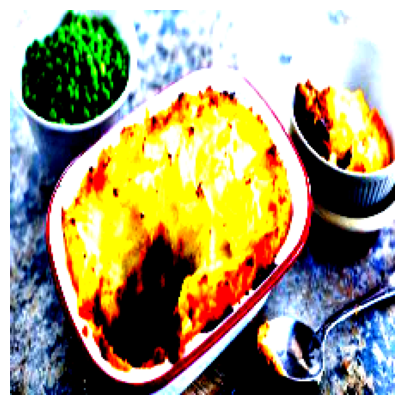

111

cottage_pie

torch.Size([128, 3, 224, 224])
torch.Size([128])

209

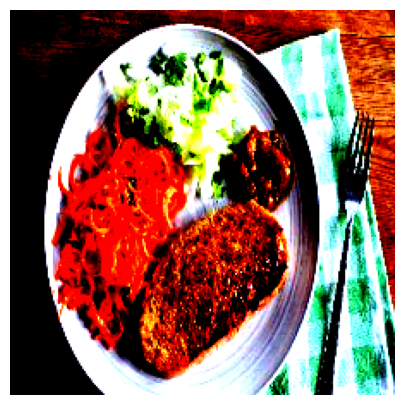

209

welsh_rarebit

torch.Size([512, 3, 224, 224])
torch.Size([512])

12

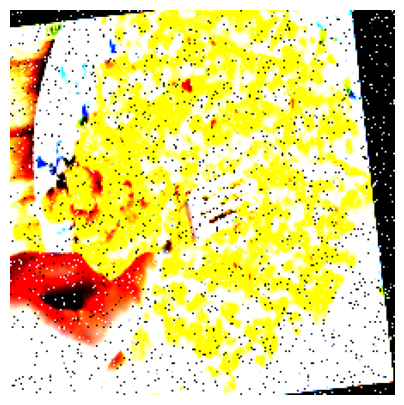

12

couscous

In [33]:
check_integrity(test_dl)
check_integrity(val_dl)
check_integrity(trn_dl)

# Convnext tiny

@article{DBLP:journals/corr/abs-2201-03545,
  author       = {Zhuang Liu and
                  Hanzi Mao and
                  Chao{-}Yuan Wu and
                  Christoph Feichtenhofer and
                  Trevor Darrell and
                  Saining Xie},
  title        = {A ConvNet for the 2020s},
  journal      = {CoRR},
  volume       = {abs/2201.03545},
  year         = {2022},
  url          = {https://arxiv.org/abs/2201.03545},
  eprinttype    = {arXiv},
  eprint       = {2201.03545},
  timestamp    = {Thu, 20 Jan 2022 14:21:35 +0100},
  biburl       = {https://dblp.org/rec/journals/corr/abs-2201-03545.bib},
  bibsource    = {dblp computer science bibliography, https://dblp.org}
}


In [34]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
def get_model():
  # model = models.vgg16(weights='DEFAULT').to(device)
  model = models.convnext_tiny(weights='DEFAULT').to(device)

  print(model)

  # Specify that we want to freeze all the parameters in the model
  # downloaded previously
  # for child in model.children():
  #   print(child)
  
  for param in model.parameters():
    param.requires_grad = False

  for param in model.features[7].parameters():
    param.requires_grad = True
  
  
  # Replace the avgpool module to return a feature map of size 1 x 1
  # instead of 7 x 7, in other words, the output is now going to be
  # batch_size x 512 (example) x 1 x 1:

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

  # The layer above, nn.AdaptiveAvgPool2d, is yet
  # another pooling layer with a twist. We specify the output feature
  # map size instead. The layer automatically computes the kernel size
  # so that the specified feature map size is returned. For example, if the
  # input feature map size dimensions were batch_size x 512 x k
  # x k, then the pooling kernel size is going to be k x k. The major
  # advantage with this layer is that whatever the input size, the output
  # from this layer is always fixed and, hence, the neural network can
  # accept images of any height and width.




  # Define the classifier module of the model, where we first flatten
  # the output of the avgpool module, connect the 512 units to the 256
  # units, and perform an activation prior to connecting to the output
  # layer:

  model.classifier[2] = nn.Sequential(
                                    nn.Linear(768, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, NUM_CLASSES)
                                    )
  
  
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-5)
  return model.to(device), loss_fn, optimizer

def get_saved_model(model):
  convnext_path = PROJ_PATH+"ConvNeXt.pth"
  state_dict = torch.load(convnext_path)
  model.load_state_dict(state_dict['state'])
  return model.to(device), state_dict['epoch']
  # model(torch.tensor(val).float().to(device))
  

In [36]:
model, loss_fn, optimizer = get_model()
model, n_epochs = get_saved_model(model)
n_epochs
# model.classifier[2] = nn.Sequential(
#                                   nn.Linear(768, 512),
#                                   nn.ReLU(),
#                                   nn.Dropout(0.2),
#                                   nn.Linear(512, NUM_CLASSES)
#                                   )

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0058823529411764705, mode=row)
      )
      (2): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.011764705882352941, mode=row)
      )
    )
    (2): Sequential(
      (0): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.017647058823529415, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.023529411764705882, mode=row)
      )
      (2): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.029411764705882353, mode=row)
      )
    )
    (4): Sequential(
      (0): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (5): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(384, 384, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=384)
          (1): Permute()
          (2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)


6

In [37]:
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1,3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 7, 7]           --
|    └─Conv2dNormActivation: 2-1              [-1, 96, 56, 56]          --
|    |    └─Conv2d: 3-1                       [-1, 96, 56, 56]          (4,704)
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 56, 56]          (192)
|    └─Sequential: 2-2                        [-1, 96, 56, 56]          --
|    |    └─CNBlock: 3-3                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-4                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-5                      [-1, 96, 56, 56]          (79,296)
|    └─Sequential: 2-3                        [-1, 192, 28, 28]         --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 56, 56]          (192)
|    |    └─Conv2d: 3-7                   

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 768, 7, 7]           --
|    └─Conv2dNormActivation: 2-1              [-1, 96, 56, 56]          --
|    |    └─Conv2d: 3-1                       [-1, 96, 56, 56]          (4,704)
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 56, 56]          (192)
|    └─Sequential: 2-2                        [-1, 96, 56, 56]          --
|    |    └─CNBlock: 3-3                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-4                      [-1, 96, 56, 56]          (79,296)
|    |    └─CNBlock: 3-5                      [-1, 96, 56, 56]          (79,296)
|    └─Sequential: 2-3                        [-1, 192, 28, 28]         --
|    |    └─LayerNorm2d: 3-6                  [-1, 96, 56, 56]          (192)
|    |    └─Conv2d: 3-7                       [-1, 192, 28, 28]         (73,920)
|    └─Sequential: 2-4                        [-1, 192, 28, 

In [38]:
def train_batch(x, y, model, opt, loss_fn, debug=False):
  '''
  This code passes the batch of images through the model in the
  forward pass. It also computes the loss on batch and then passes the
  weights through backward propagation and updates them. Finally, it
  flushes the memory of the gradient so that it doesn't influence how the
  gradient is calculated in the next pass.
  '''
  model.train() # <- let's hold on to this until we reach dropout section


  # ----------------------------------
  # call your model like any python function on your batch
  # of inputs
  # see this: https://discuss.pytorch.org/t/why-the-torch-max-of-predictions-and-f-softmax-pred-are-equal-and-what-is-the-logic-behind-this/141019/2
  prediction = model(x)
  _, argmaxes_prediction = torch.max(prediction, dim=1) 
  # ----------------------------------

  if debug:
    print("\n\n\n ---------------------------------- PREDICTION ----------------------------------")
    print(prediction.detach().cpu().numpy()[0])
    print(prediction.detach().cpu().numpy()[1])
    
    print(argmaxes_prediction.detach().cpu().numpy())


    print("--------------------------------- GT ----------------------------------")
    print(y)
    print(y.cpu().numpy())



  # ----------------------------------
  # compute loss
  l2_regularization = 0 # l2 regularization
  for param in model.parameters():
    l2_regularization += torch.norm(param,2)
  
  batch_loss = loss_fn(prediction, y) + 0.001*l2_regularization
  # ----------------------------------


  # ----------------------------------
  # based on the forward pass in `model(x)` compute all the
  # gradients of 'model.parameters()'
  batch_loss.backward()
  # ----------------------------------


  # ----------------------------------
  # apply new-weights = f(old-weights, old-weight-gradients)
  # where "f" is the optimizer
  optimizer.step()
  # ----------------------------------


  # ----------------------------------
  # Flush gradients memory for next batch of calculations
  optimizer.zero_grad()
  if debug:
    print(batch_loss.item())

  return batch_loss.item() # Now that we've done this, we can extract the loss value as a scalar by fetching batch_loss.item() on top of batch_loss
  # ----------------------------------


# since there's no need for updating weights,
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):

  # ----------------------------------
  # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
  # during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
  # You need to turn them off during model evaluation, and .eval() will do it for you. 
  # In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation.
  # from: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
  model.eval() # <- let's wait till we get to dropout section
  # ----------------------------------



  # ----------------------------------
  # get the prediction matrix for a tensor of `x` images
  prediction = model(x)
  # In the following lines of code, we are explicitly mentioning that we don't
  # need to calculate the gradient by providing @torch.no_grad() and
  # calculating the prediction values by feed-forwarding input through the
  # model
  # ----------------------------------




  # ----------------------------------
  # compute if the location of maximum in each row
  # coincides with ground truth
  # we invoke prediction.max(-1) to identify the argmax index corresponding to each row.
  max_values, argmaxes = prediction.max(1) 
  # max_values_y, argmaxes_y = y.max(-1) 
  # ----------------------------------



  # ----------------------------------
  # Furthermore, we are comparing our argmaxes with the ground truth
  # through argmaxes == y so that we can check whether each row is
  # predicted correctly.
  is_correct = argmaxes == y
  # ----------------------------------



  # ----------------------------------
  return is_correct.cpu().numpy().tolist() # Finally, we are returning the list of is_correct objects after moving it to a CPU and converting it into a numpy array.
  # ----------------------------------




# Define a function that calculates the loss of the validation data; that
# is, val_loss. Note that we are calculating this separately since loss of
# training data is getting calculated while training the model
@torch.no_grad()
def val_loss(x, y, model):
  # As you can see, we are applying torch.no_grad because we are not
  # training the model and only fetching predictions. Furthermore, we are
  # passing our prediction through the loss function (loss_fn) and
  # returning the loss value (val_loss.item()).
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [39]:

# acc = []
# for ix, batch in enumerate(iter(test_dl)):
#   x, y = batch
#   is_correct = accuracy(x, y, model)
#   acc.extend(is_correct)

# np.mean(acc)

In [40]:
from torch import optim

def start_training(epochs=10):
  log = Report(epochs)
  
  # we are specifying that we're reducing the learning rate
  # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
  
 
  # Invoke the lists that contain the accuracy and loss values at the end of each epoch
  train_losses, train_accuracies = [], [] 
  val_losses, val_accuracies = [], []


  for epoch in range(epochs): # Define the number of epochs
    print(f" epoch {epoch + 1}/{epochs}")


    #--------------------------------
    # Invoke the lists that will contain the accuracy and loss values
    # corresponding to each batch within an epoch
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_losses, val_epoch_accuracies = [], []
    #--------------------------------



    #--------------------------------
    N = len(trn_dl)
    for ix, batch in enumerate(iter(trn_dl)): # Create batches of training data by iterating through the DataLoader
      x, y = batch
      
      # Train the batch using the train_batch function and store the loss value at
      # the end of training on top of the batch as batch_loss. Furthermore, store
      # the loss values across batches in the epoch_losses list:

      batch_loss = train_batch(x, y, model, optimizer, loss_fn, debug=False)
      train_epoch_losses.append(batch_loss)
      log.record(epoch+(ix+1)/N, trn_loss=batch_loss, end='\r')

    # We store the mean loss value across all batches within an epoch:
    train_epoch_loss = np.array(train_epoch_losses).mean()
    #--------------------------------
    save_model(model, epoch+n_epochs)



    #--------------------------------
    # Next, we calculate the accuracy of the prediction at the end of training on
    # all batches:
    for ix, batch in enumerate(iter(trn_dl)):
      x, y = batch
      is_correct = accuracy(x, y, model)
      train_epoch_accuracies.extend(is_correct)

    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    #--------------------------------


    #--------------------------------
    N = len(val_dl)
    for ix, batch in enumerate(iter(val_dl)):
      x, y = batch

      validation_loss = val_loss(x, y, model)
      val_epoch_losses.append(validation_loss)
      log.record(epoch+(ix+1)/N, val_loss=validation_loss, end='\r')
    
    val_epoch_losses = np.array(val_epoch_losses).mean()
    #--------------------------------




    #--------------------------------
    for ix, batch in enumerate(iter(val_dl)):
      x, y = batch

      val_is_correct = accuracy(x, y, model)
      val_epoch_accuracies.extend(val_is_correct)
    
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    #--------------------------------



    #--------------------------------
    # Store the loss and accuracy values at the end of each epoch in a list

    log.report_avgs(epoch+1)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_losses)

    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    #--------------------------------
    

    print("Accuracy = {}".format(train_epoch_accuracy))
    print("Accuracy Validation= {}".format(val_epoch_accuracy))

    #--------------------------------
    # if (epoch+1)%2 == 0:
    # save_model(model, epoch)
    #--------------------------------

  log.plot_epochs()
  return train_losses, train_accuracies, val_losses, val_accuracies
    

In [41]:

epochs = 3


In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = start_training(epochs)

epoch 1/3

EPOCH: 0.210  trn_loss: 4.724  (357.93s - 4755.38s remaining)

In [ ]:
epochs = np.arange(epochs)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()